In [0]:
!pip3 install sklearn-contrib-lightning

In [0]:
import numpy as np
import numpy.linalg as la
from scipy import stats 
import matplotlib.pyplot as graph
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from lightning.regression import FistaRegressor

graph.style.use('fivethirtyeight')

# Lasso

In [0]:
# Lasso toy data
n = int(1e3)
p = 250
k = 4

beta = np.zeros(p)
beta[:4] = [2, -2, 2, 3]
print(beta)

x = stats.norm().rvs(size=(n, p))
y = x @ beta
y += 2.5*stats.norm().rvs(n)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

print(x.shape, y.shape)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

[ 2. -2.  2.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

Easily readable form.

$ J(m) = {{1}\over{2N}} \sum(y - Xm)^2 + \lambda \sum|w_i m_i|$

Form actually solved.

$ J(m) = {{1}\over{2N}} ||y - Xm||_2^2 + \lambda ||w\circ m||_1 $

In [0]:
# Custom Penalty Object
class SimpleLasso:
    def __init__(self, w):
        self.w = w
        
    def projection(self, coef, alpha, L):
        return np.sign(coef) * np.maximum(abs(coef) - ((self.w * alpha) / L), 0)
    
    def regularization(self, coef):
        return la.norm(self.w * coef, 1)
    
def compute_lam_max(x, y):
    n = len(y)
    dots = np.zeros(x.shape[1])
    for j in range(len(dots)):
        dots[j] = x[:, j].T @ y
    return np.abs(dots).max() / n

In [0]:
%%timeit
#FISTA
test = FistaRegressor(C=1/len(y), penalty=SimpleLasso(np.ones(p)), alpha=1e2)
test.fit(x_train, y_train)

10 loops, best of 3: 142 ms per loop


In [0]:
%%time
# Training Lasso with FISTA
lambda_max = compute_lam_max(x_train, y_train)
lambda_min = 1e-3 * lambda_max
lambda_path = np.logspace(np.log10(lambda_max), np.log10(lambda_min), 50)
beta_path = []
score_path = []
for lam_i in lambda_path:
    reg_strength = np.ones(p)
    reg_strength[2] = 0
    model = FistaRegressor(
        C=1/len(y),
        penalty=SimpleLasso(reg_strength), 
        alpha=lam_i
    )
    model.fit(x_train, y_train)
    
    beta_path.append(model.coef_)
    score_path.append(
        r2_score(y_test, model.predict(x_test))
    )

beta_path = np.vstack(beta_path)

CPU times: user 9.99 s, sys: 4.99 s, total: 15 s
Wall time: 7.52 s


In [0]:
np.array([1, 2, 3]).mean()

2.0

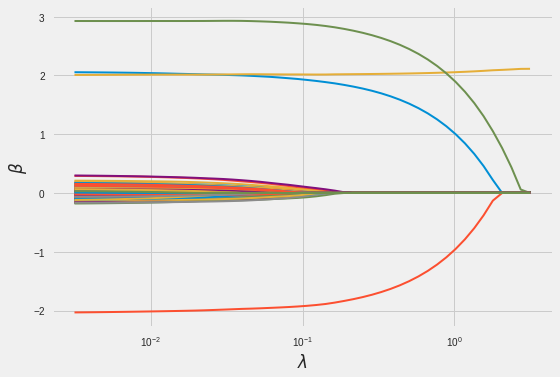

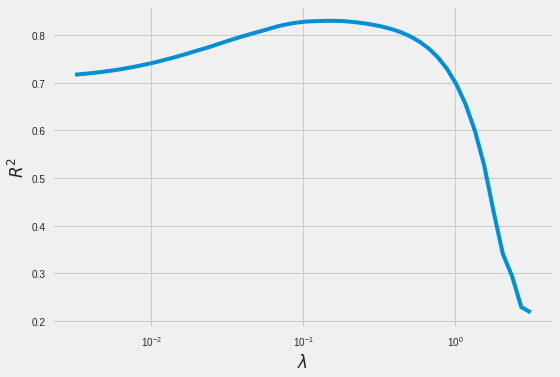

In [0]:
graph.plot(lambda_path, beta_path, linewidth=2)
graph.xscale('log')
graph.ylabel(r'$\beta$')
graph.xlabel(r'$\lambda$')
graph.show()

graph.plot(lambda_path, score_path)
graph.xscale('log')
graph.ylabel(r'$R^2$')
graph.xlabel(r'$\lambda$')
graph.show()